Run linear SVM with additional feature of scanner type - see if linear SVM can learn it and not let it influence the results

In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load data from CSV file
# Load your connectivity data
# Assuming X is an n_subjects x n_connections matrix (connectivity features) 
# and y is a vector of labels (delirium: 1 for yes, 0 for no)
file_path = "/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/FC/flat_fc_edges_all_subjects.csv"
X = pd.read_csv(file_path, header=None, sep=",")

clinic_data = pd.read_csv("/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Demographic_Data/subject_data_IL810_mri.csv", header=0, sep=",")
y = clinic_data[['bin_delirium']]

mri_scanner_data = pd.read_csv("/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Demographic_Data/mri_scanner_current.csv", header=0, sep=",")
mri_scan_type = mri_scanner_data[['mri_scanner_used']]

KeyboardInterrupt: 

In [6]:
#group together both the connectivity data and the mri scanner type
fc_all_mriscanner = pd.concat([X, mri_scan_type], axis=1)

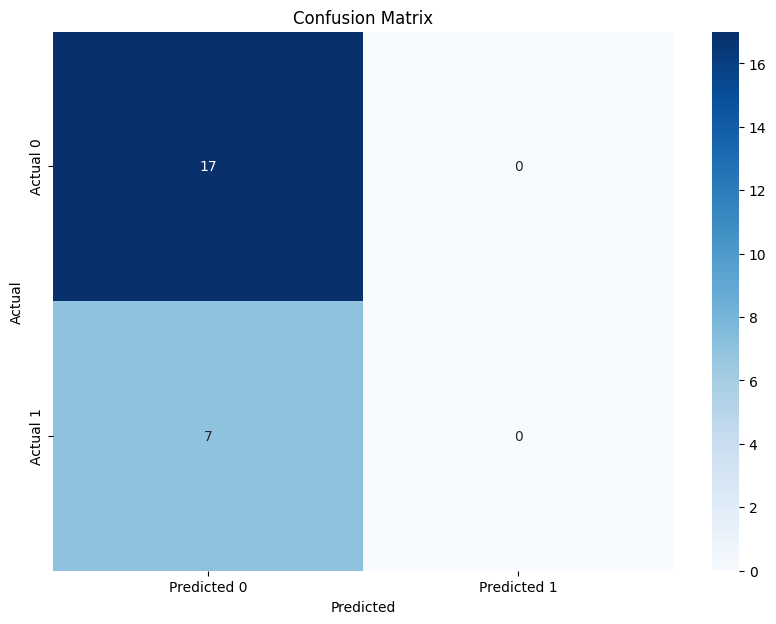

Accuracy of balanced SVM with MRI scanner factor: 0.7083333333333334
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        17
           1       0.00      0.00      0.00         7

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

[[17  0]
 [ 7  0]]


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#make X equal whatever set of data & features
X = fc_all_mriscanner
X.columns = X.columns.astype(str)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale features (SVMs work better with scaled data)
# Ensure y_train and y_test are 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the SVM model
svm_balanced = SVC(kernel='linear', class_weight='balanced', random_state=42)  # Use linear kernel for interpretability
svm_balanced.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_balanced.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print("Accuracy of balanced SVM with MRI scanner factor:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

Best parameters found: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best parameters found: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}


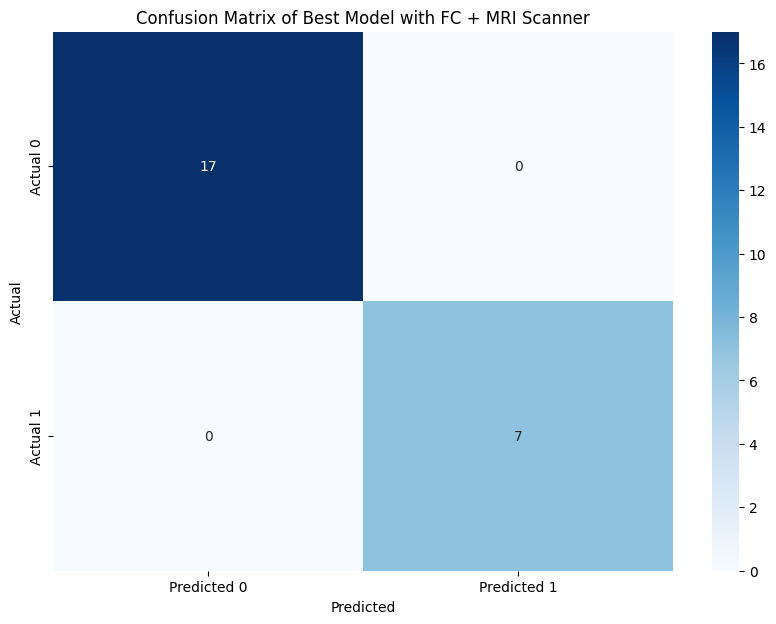

Accuracy of best SVM with MRI scanner factor: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

[[17  0]
 [ 0  7]]


In [13]:
from sklearn.model_selection import GridSearchCV
#using the SMOTE data for training and parameter estimation
#find the best gamma parameter
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear','rbf'], 'gamma': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_test, y_test)

print("Best parameters found:", grid_search.best_params_)
# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Best Model with FC + MRI Scanner')
plt.show()

# Print evaluation metrics
print("Accuracy of best SVM with MRI scanner factor:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

Best parameters found for the SVM linear model including the MRI scanner type

In [16]:
# show the best model coefficients
# Access the learned coefficients from the linear SVM
importance_weights = best_model.coef_.flatten()  # Flatten in case it's in 2D

# Sort the coefficients by absolute value to find the most important connections
sorted_indices = np.argsort(np.abs(importance_weights))[::-1]  # Sort in descending order

# Print the sorted importance weights and their corresponding feature index
print("Top 10 most predictive connections:")
for i in sorted_indices[:10]:  # Print the top 10 features
    print(f"Connection {i}: Coefficient = {importance_weights[i]}")


Top 10 most predictive connections:
Connection 39201: Coefficient = -0.0010621058179950869
Connection 49815: Coefficient = -0.0009951198741371145
Connection 43312: Coefficient = -0.0009774313152665136
Connection 257: Coefficient = -0.0009740585937680282
Connection 52477: Coefficient = -0.000970398875214268
Connection 403: Coefficient = -0.0009550791625969129
Connection 40036: Coefficient = -0.0009417506532194168
Connection 36934: Coefficient = -0.0008848269197294903
Connection 54936: Coefficient = -0.0008800460526381473
Connection 59205: Coefficient = -0.00087854251446881


Avg. FC across/within Networks

In [17]:
# load in relevant data
file_path = "/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/FC/avg_within_across_cort_networks.csv"
X = pd.read_csv(file_path, header=None, sep=",")

mri_scanner_data = pd.read_csv("/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Demographic_Data/mri_scanner_current.csv", header=0, sep=",")
mri_scan_type = mri_scanner_data[['mri_scanner_used']]

#concatenate the relevant data together 
fc_avg_mriscanner = pd.concat([X, mri_scan_type], axis=1)

In [5]:
# load in relevant data - from desktop local
file_path = "/Users/ntaylor/Desktop/lm_model_delirium/avg_within_across_cort_networks.csv"
X = pd.read_csv(file_path, header=None, sep=",")

clinic_data = pd.read_csv("/Users/ntaylor/Desktop/lm_model_delirium/subject_data_IL810_mri.csv", header=0, sep=",")
y = clinic_data[['bin_delirium']]

mri_scanner_data = pd.read_csv("/Users/ntaylor/Desktop/lm_model_delirium//mri_scanner_current.csv", header=0, sep=",")
mri_scan_type = mri_scanner_data[['mri_scanner_used']]

#concatenate the relevant data together 
fc_avg_mriscanner = pd.concat([X, mri_scan_type], axis=1)

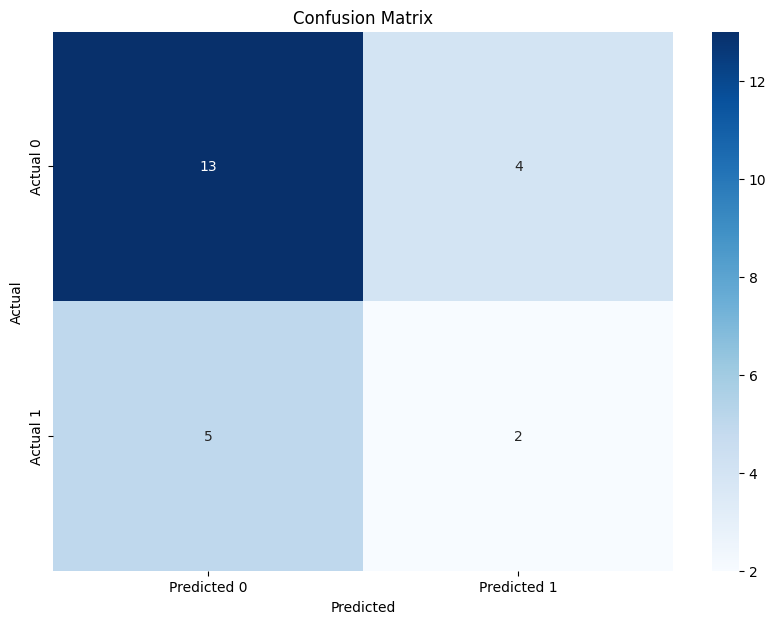

Accuracy of balanced SVM with MRI scanner factor: 0.625
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.33      0.29      0.31         7

    accuracy                           0.62        24
   macro avg       0.53      0.53      0.53        24
weighted avg       0.61      0.62      0.62        24

[[13  4]
 [ 5  2]]


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#make X equal whatever set of data & features
X = fc_avg_mriscanner 
X.columns = X.columns.astype(str)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale features (SVMs work better with scaled data)
# Ensure y_train and y_test are 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the SVM model
svm_balanced = SVC(kernel='linear', class_weight='balanced', random_state=42)  # Use linear kernel for interpretability
svm_balanced.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_balanced.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print("Accuracy of balanced SVM with MRI scanner factor:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

Best parameters found: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


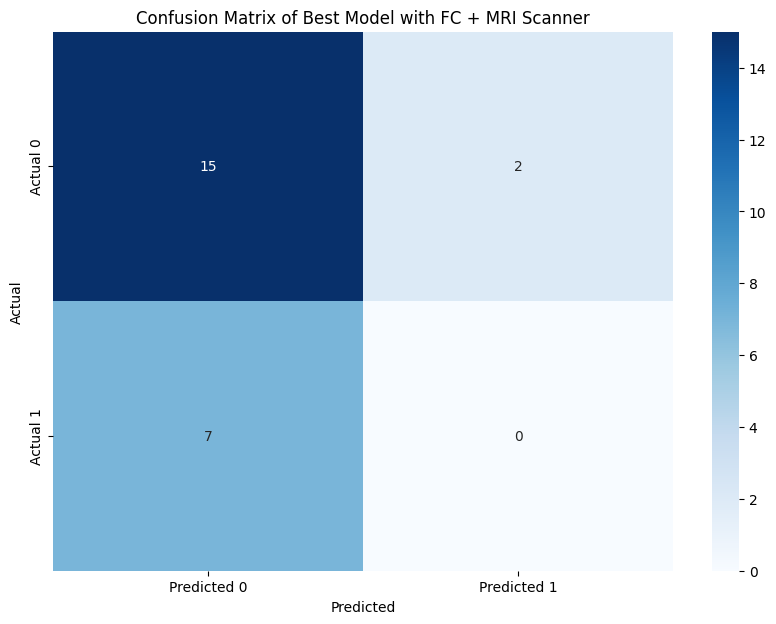

Accuracy of best SVM with MRI scanner factor: 0.625
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        17
           1       0.00      0.00      0.00         7

    accuracy                           0.62        24
   macro avg       0.34      0.44      0.38        24
weighted avg       0.48      0.62      0.54        24

[[15  2]
 [ 7  0]]


In [21]:
#optimisation of hyperparameters
#find the best gamma parameter
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear','rbf'], 'gamma': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Best Model with FC + MRI Scanner')
plt.show()


# Print evaluation metrics
print("Accuracy of best SVM with MRI scanner factor:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

Attempt to regress out the mri scanner type from FC first - then run the linear SVM

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [6]:
from sklearn.linear_model import LinearRegression

In [11]:
# regress out the scanner type from the avg. within network
# Assuming X is a DataFrame and mri_scanner_type is a Series or DataFrame
X = pd.DataFrame(X)  # Convert X to DataFrame if it's not already
X.columns = X.columns.astype(str)  # Ensure all column names are strings

# Use the column directly if mri_scan_type is a DataFrame with a single column
if isinstance(mri_scan_type, pd.DataFrame) and mri_scan_type.shape[1] == 1:
    mri_scan_type = mri_scan_type.iloc[:, 0]

# One-hot encode if categorical
mri_scan_type = pd.get_dummies(mri_scan_type, drop_first=True)
mri_scan_type['intercept'] = 1  # Add intercept

# Ensure all column names in mri_scan_type are strings
mri_scan_type.columns = mri_scan_type.columns.astype(str)

# Initialize the Linear Regression model
model = LinearRegression()

# Regress out mri_scan_type from each feature in X
X_residuals = pd.DataFrame(index=X.index, columns=X.columns)
for column in X.columns:
    model.fit(mri_scan_type, X[column])
    X_residuals[column] = X[column] - model.predict(mri_scan_type)

# X_residuals now contains the features with the effect of mri_scan_type regressed out
print(X_residuals.head())

          0         1         2         3         4         5         6  \
0  0.192128  0.065461  0.161868 -0.065676 -0.024758 -0.022533 -0.033769   
1  0.020776  0.029323  0.066825  0.027166  0.070851  0.107171  0.148348   
2 -0.171371 -0.098720 -0.118722 -0.067848 -0.019026 -0.054881 -0.022657   
3  0.032938  0.007827  0.015499 -0.006200 -0.007271  0.009621  0.002755   
4 -0.094971 -0.106075 -0.093645 -0.102404 -0.076155 -0.078519 -0.084823   

          7         8         9  ...        54        55        56        57  \
0 -0.005510  0.065461  0.018184  ... -0.074891 -0.070591 -0.005510  0.081202   
1  0.112397  0.029323 -0.016010  ...  0.086442  0.119538  0.112397  0.069687   
2 -0.091661 -0.098720 -0.116755  ... -0.082744 -0.079868 -0.091661 -0.083865   
3  0.023216  0.007827 -0.034038  ... -0.095346 -0.052164  0.023216  0.016246   
4 -0.014110 -0.106075 -0.118967  ... -0.161999 -0.085370 -0.014110 -0.106103   

         58        59        60        61        62        63  
0  0

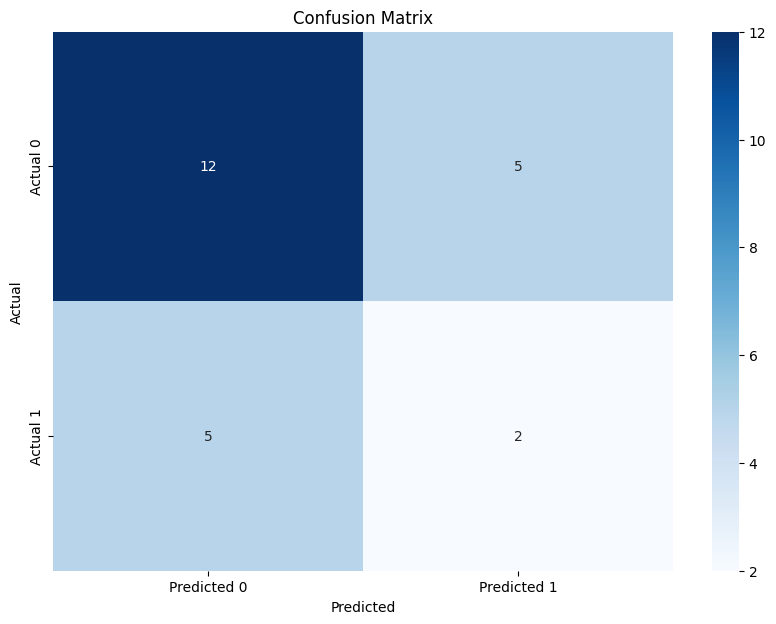

Accuracy of balanced SVM with MRI scanner factor: 0.5833333333333334
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.29      0.29      0.29         7

    accuracy                           0.58        24
   macro avg       0.50      0.50      0.50        24
weighted avg       0.58      0.58      0.58        24

[[12  5]
 [ 5  2]]


In [12]:
#run the linear SVM with the regressed out FC matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#make X equal whatever set of data & features
X = X_residuals 
X.columns = X.columns.astype(str)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale features (SVMs work better with scaled data)
# Ensure y_train and y_test are 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the SVM model
svm_balanced = SVC(kernel='linear', class_weight='balanced', random_state=42)  # Use linear kernel for interpretability
svm_balanced.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_balanced.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print("Accuracy of balanced SVM with MRI scanner factor:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

Best parameters found: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


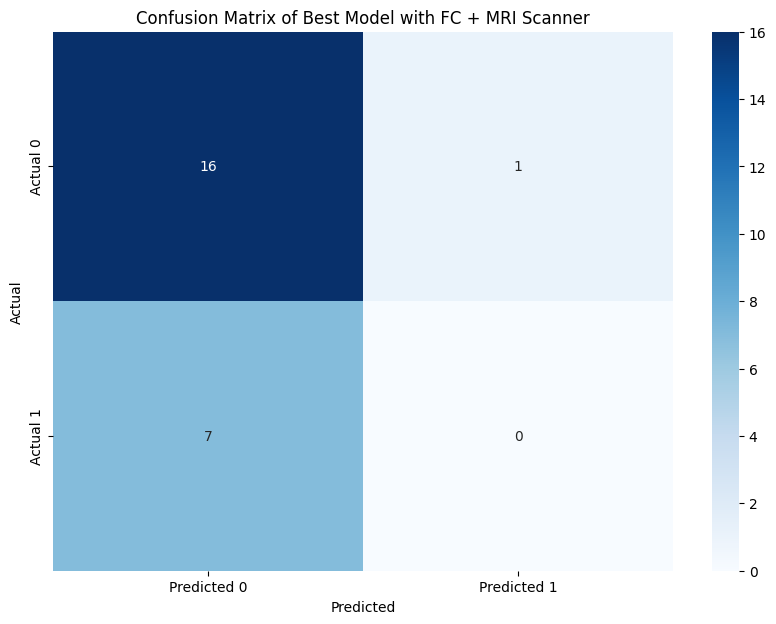

Accuracy of best SVM with MRI scanner factor: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.70      0.94      0.80        17
           1       0.00      0.00      0.00         7

    accuracy                           0.67        24
   macro avg       0.35      0.47      0.40        24
weighted avg       0.49      0.67      0.57        24

[[16  1]
 [ 7  0]]


In [14]:
# hyperparameter setting
from sklearn.model_selection import GridSearchCV
#optimisation of hyperparameters
#find the best gamma parameter
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear','rbf'], 'gamma': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Best Model with FC + MRI Scanner')
plt.show()


# Print evaluation metrics
print("Accuracy of best SVM with MRI scanner factor:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

Also run with additional cognitive factors - Adding the additional age, moca, tmt-diff and dsst score as additional features

In [ ]:
# merge the relevant cog data + avg. within network
x2 = cog_data[['patient_age','moca_total','tmt_diff','dsst_score']]

# merge together avg FC within networks + cog and age data
X_features = pd.concat([X, x2], axis=1)